<a href="https://colab.research.google.com/github/AbdallaAbuamsha/GloVe/blob/master/GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset_path='gdrive/My Drive/output_cleaned_tokenized.txt'

In [ ]:
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE

In [ ]:
class GloveDataset:

        def __init__(self, text, n_words=200000, window_size=5):
            self._window_size = window_size
            self._tokens = text.split(" ")[:n_words]
            word_counter = Counter()
            word_counter.update(self._tokens)
            self._word2id = {w:i for i, (w,_) in enumerate(word_counter.most_common())}
            self._id2word = {i:w for w, i in self._word2id.items()}
            self._vocab_len = len(self._word2id)

            self._id_tokens = [self._word2id[w] for w in self._tokens]

            self._create_coocurrence_matrix()

            print("# of words: {}".format(len(self._tokens)))
            print("Vocabulary length: {}".format(self._vocab_len))

        def _create_coocurrence_matrix(self):
            cooc_mat = defaultdict(Counter)
            for i, w in enumerate(self._id_tokens):
                start_i = max(i - self._window_size, 0)
                end_i = min(i + self._window_size + 1, len(self._id_tokens))
                for j in range(start_i, end_i):
                    if i != j:
                        c = self._id_tokens[j]
                        cooc_mat[w][c] += 1 / abs(j-i)

            self._i_idx = list()
            self._j_idx = list()
            self._xij = list()

            #Create indexes and x values tensors
            for w, cnt in cooc_mat.items():
                for c, v in cnt.items():
                    self._i_idx.append(w)
                    self._j_idx.append(c)
                    self._xij.append(v)

            self._i_idx = torch.LongTensor(self._i_idx).cuda()
            self._j_idx = torch.LongTensor(self._j_idx).cuda()
            self._xij = torch.FloatTensor(self._xij).cuda()


        def get_batches(self, batch_size):
            #Generate random idx
            rand_ids = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))

            for p in range(0, len(rand_ids), batch_size):
                batch_ids = rand_ids[p:p+batch_size]
                yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]
dataset = GloveDataset(open(dataset_path).read(), 10000000)

# of words: 10000000
Vocabulary length: 793156


In [ ]:
EMBED_DIM = 100
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j

        return x
glove = GloveModel(dataset._vocab_len, EMBED_DIM)
glove.cuda()

GloveModel(
  (wi): Embedding(793156, 100)
  (wj): Embedding(793156, 100)
  (bi): Embedding(793156, 1)
  (bj): Embedding(793156, 1)
)

In [ ]:
#set this manualy for now

last_saved_epoch = 0
if last_saved_epoch != 0 and path.exists('drive/My Drive/wiki_ar_dataset/ModelBackups/glove_light_10dim_1m_e'+last_saved_epoch+'.pt'):
        glove.load_state_dict('drive/My Drive/wiki_ar_dataset/ModelBackups/glove_light_10dim_1m_e'+last_saved_epoch+'.pt')

In [ ]:
def weight_func(x, x_max, alpha):
    wx = (x/x_max)**alpha
    wx = torch.min(wx, torch.ones_like(wx))
    return wx.cuda()

In [ ]:
def wmse_loss(weights, inputs, targets):
    loss = weights * F.mse_loss(inputs, targets, reduction='none')
    return torch.mean(loss).cuda()

In [ ]:
optimizer = optim.Adagrad(glove.parameters(), lr=0.05)


In [ ]:
print(dataset._tokens[:1000])

['خلقة', 'الخلقة', 'هو', 'مجموعة', 'من', 'التصرفات', 'المستفادة', 'اجتماعيا،', 'والمهارات', 'وطرق', 'العمل،', 'التي', 'غالبا', 'ما', 'تتخذ', 'من', 'المسلمات،', 'والتي', 'يتم', 'الحصول', 'عليها', 'من', 'خلال', 'أنشطة', 'وتجارب', 'الحياة', 'اليومية.يعد', 'مفهوم', 'الهابيتوس', 'من', 'المفاهيم', 'الراسخة', 'في', 'نظرية', 'بورديو', 'في', 'مجال', 'الأنساق', 'التربوية.\nوقد', 'تناول', 'هذا', 'المفهوم', 'واستخدمه', 'لأول', 'مرة', 'في', 'كتابه', 'نظرية', 'الممارسة', 'في', 'ثمانينات', 'القرن', 'الماضي.يترجم', 'هذا', 'المصطلح', 'في', 'العربية', 'بلفظ', 'الخلقة', 'أو', 'السجية', 'التي', 'توجه', 'السلوك', 'توجيها', 'عفويا', 'وتلقائيا', 'ويأخذ', 'هذا', 'المفهوم', 'أهميته', 'في', 'نسق', 'المفاهيم', 'المركزية', 'عند', 'بيير', 'بورديو', 'مثل', 'الحقل', 'والرمز', 'والعنف', 'الرمزي', 'يعد', 'مفهوم', 'الهابيتوس', 'من', 'المفاهيم', 'الأساسية', 'المركزية', 'في', 'سوسيولوجيا', 'بورديو', 'وأكثرها', 'إثارة', 'للجدل.\nفمنذ', 'سبعينات', 'القرن', 'الماضي', 'حتى', 'مطلع', 'القرن', 'الحادي', 'والعشرين', 'كان', 'بور

In [ ]:
N_EPOCHS = 100
BATCH_SIZE = 2048
X_MAX = 100
ALPHA = 0.75
n_batches = int(len(dataset._xij) / BATCH_SIZE)
loss_values = list()
for e in range(1, N_EPOCHS+1):
    batch_i = 0

    for x_ij, i_idx, j_idx in dataset.get_batches(BATCH_SIZE):

        batch_i += 1

        optimizer.zero_grad()

        outputs = glove(i_idx, j_idx)
        weights_x = weight_func(x_ij, X_MAX, ALPHA)
        loss = wmse_loss(weights_x, outputs, torch.log(x_ij))

        loss.backward()

        optimizer.step()

        loss_values.append(loss.item())

        if batch_i % 100 == 0:
            print("Epoch: {}/{} \t Batch: {}/{} \t Loss: {}".format(e, N_EPOCHS, batch_i, n_batches, np.mean(loss_values[-20:])))


    print("Saving model...")
    torch.save(glove.state_dict(), "glove_light_10dim_1m.pt")
    torch.save(glove.state_dict(), "drive/My Drive/wiki_ar_dataset/ModelBackups/glove_light_10dim_1m_e"+i+".pt")


Epoch: 1/100 	 Batch: 100/23824 	 Loss: 0.03872041869908571
Epoch: 1/100 	 Batch: 200/23824 	 Loss: 0.03895500972867012
Epoch: 1/100 	 Batch: 300/23824 	 Loss: 0.038505404442548755
Epoch: 1/100 	 Batch: 400/23824 	 Loss: 0.036744465492665766
Epoch: 1/100 	 Batch: 500/23824 	 Loss: 0.038565540313720705
Epoch: 1/100 	 Batch: 600/23824 	 Loss: 0.03789243195205927
Epoch: 1/100 	 Batch: 700/23824 	 Loss: 0.038727936893701555
Epoch: 1/100 	 Batch: 800/23824 	 Loss: 0.03685372769832611
Epoch: 1/100 	 Batch: 900/23824 	 Loss: 0.03631923701614141
Epoch: 1/100 	 Batch: 1000/23824 	 Loss: 0.039517590776085854
Epoch: 1/100 	 Batch: 1100/23824 	 Loss: 0.03844162076711655
Epoch: 1/100 	 Batch: 1200/23824 	 Loss: 0.038950884528458116
Epoch: 1/100 	 Batch: 1300/23824 	 Loss: 0.03762021642178297
Epoch: 1/100 	 Batch: 1400/23824 	 Loss: 0.037437616102397445
Epoch: 1/100 	 Batch: 1500/23824 	 Loss: 0.036735286749899385
Epoch: 1/100 	 Batch: 1600/23824 	 Loss: 0.040169093385338785
Epoch: 1/100 	 Batch: 17

NameError: ignored

In [ ]:
model_save_name = 'glove_100000_with_stopwords1.txt'
path = F"/content/gdrive/My Drive/glove_100000_with_stopwords1.txt" 
torch.save(glove.state_dict(), path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


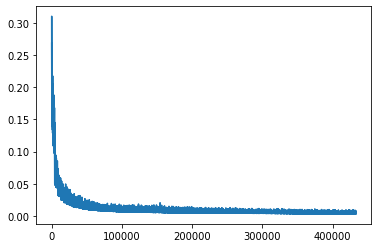

In [ ]:
plt.plot(loss_values)


In [ ]:
!pip install arabic_reshaper python-bidi

  Created wheel for arabic-reshaper: filename=arabic_reshaper-2.1.0-cp36-none-any.whl size=16502 sha256=5660b7c12aba05a3b93a1536fc24fd9536bccfa3904ab60ac15c04bf95cf9754
  Stored in directory: /root/.cache/pip/wheels/a9/e6/ec/2ba48138d4447d40442dd6ba3bf6b92d9c6afd74e9c720c6fe
Successfully built arabic-reshaper


In [ ]:
from bidi.algorithm import get_display
import arabic_reshaper


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


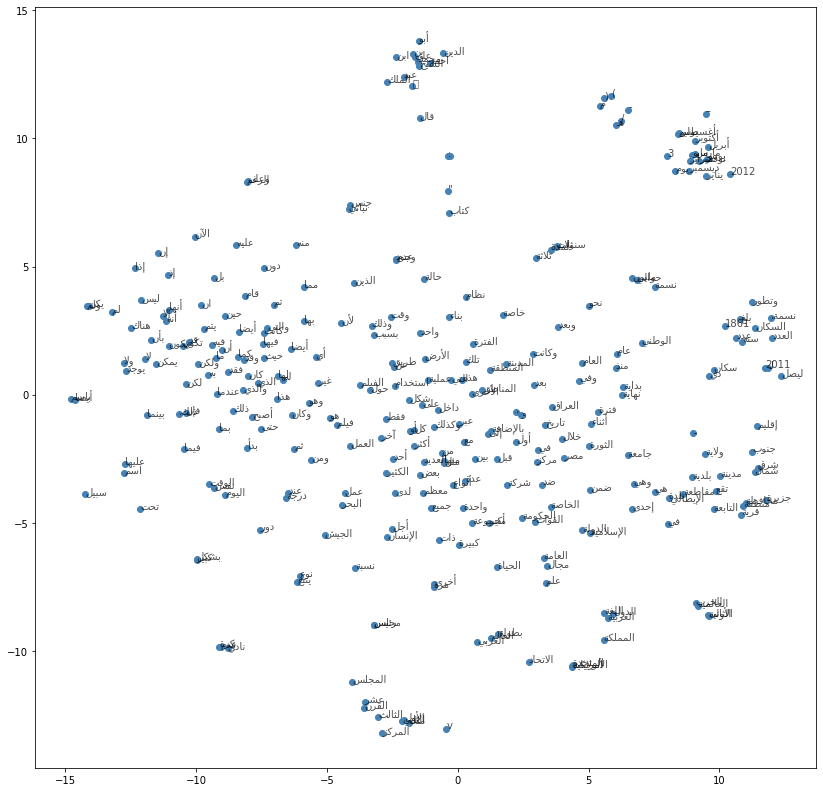

In [ ]:
emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
emb = emb_i + emb_j
top_k = 300
tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(emb[:top_k, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
    reshaped_text = arabic_reshaper.reshape(dataset._id2word[idx])
    artext = get_display(reshaped_text)
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(artext, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [ ]:
def similarity(v,u):
  return np.dot(v,u)/(np.linalg.norm(v)*np.linalg.norm(u))

print(similarity(embed_tsne[dataset._word2id["ولاية"]], embed_tsne[dataset._word2id["مدينة"]])) # = 0.5035
print(similarity(embed_tsne[dataset._word2id["ولاية"]], embed_tsne[dataset._word2id["المجلس"]])) # = 0.158

0.99769765
-0.10741777


In [ ]:
def print_closest_words(vec, n=5):
    dists = np.linalg.norm(emb - vec,axis=1)     # compute distances to all words
    print(dists)
    lst = sorted(enumerate(dists), key=lambda x: x[1]) # sort by distance
    for idx, difference in lst[1:n+1]: 					       # take the top n
        print(dataset._id2word[idx], difference)
word2 = emb[dataset._word2id["مدينة"]]
print_closest_words(word2, n=10)

[4.690572 4.969833 4.512942 ... 8.143437 8.432964 8.341923]
وهي 2.8956978
منطقة 3.1288023
ضمن 3.1700394
وسط 3.1952655
هي 3.275944
و 3.35826
مثل 3.3880243
داخل 3.4545372
العراق 3.4716773
عمل 3.4821332
